In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import requests

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io

Data is available from:  
https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/

In [52]:
uploaded = files.upload()

Saving UNSW_NB15_training-set.csv to UNSW_NB15_training-set (1).csv


In [0]:
df = pd.read_csv(io.StringIO(uploaded['UNSW_NB15_training-set.csv'].decode('utf-8')))

The UNSW-NB15 dataset is a mix of real network traffic and synthetic malware attacks. The purpose of the dataset is for research into network intrusion. Below is a quick summary EDA of the dataset. This is undirected and is used just to get an introduction to what the dataset contains.

In [54]:
#Get a sample of a few datapoints

sample_df = df.sample(5).T
sample_df.sort_values(by='label',axis=1)

,7832,15087,88255,117329,149645
id,7833,15088,88256,117330,149646
dur,0.040661,0.001014,0.412941,9e-06,0.998291
proto,tcp,udp,tcp,udp,tcp
service,-,dns,-,dns,-
state,FIN,CON,FIN,INT,FIN
spkts,48,2,10,2,10
dpkts,50,2,6,0,8
sbytes,2974,146,588,114,1030
dbytes,30506,178,268,0,354
rate,2385.58,2958.58,36.3248,111111,17.0291


In [55]:
df.shape

(175341, 45)

In [163]:
print('Number of total attacks:',df.label.sum(),'out of 175341')
print('Percent attacks:',round(df.label.mean(),2)*100,'%')

Number of total attacks: 119341 out of 175341
Percent attacks: 68.0 %


In [57]:
#Types of attacks:
df.attack_cat.value_counts()

Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

In [58]:
# Create a reference table for features that is easy to consult
# Code from https://www.kaggle.com/tombresee/next-gen-eda

refer = pd.DataFrame(df.columns)
refer.columns=['Mapper']
refer.index.name='Ref:'
refer.style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

,Mapper
Ref:,
0,id
1,dur
2,proto
3,service
4,state
5,spkts
6,dpkts
7,sbytes
8,dbytes


In [59]:
df.dtypes.value_counts()

int64      30
float64    11
object      4
dtype: int64

In [60]:
df.dtypes[df.dtypes == 'object']

proto         object
service       object
state         object
attack_cat    object
dtype: object

In [0]:
corr = df.corr()

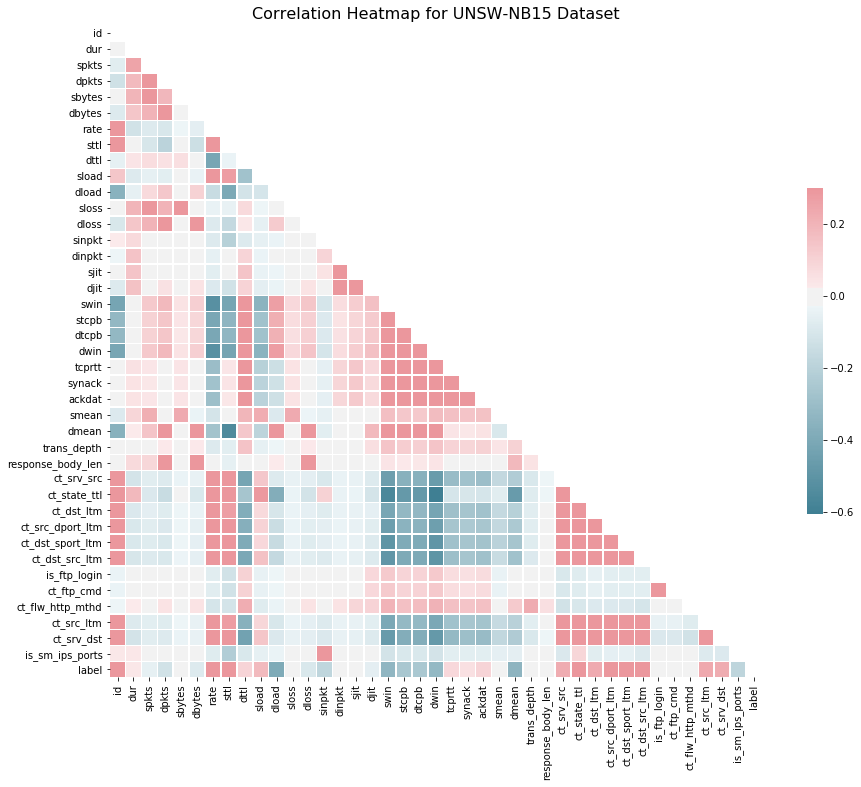

In [168]:
#correlation matrix for the data set
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(16,12))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.title('Correlation Heatmap for UNSW-NB15 Dataset', fontsize = 16)

plt.savefig('UNSW_corr.png',format='png')
files.download('UNSW_corr.png')

A correlation matrix is useful on numeric data, but what about the 3 non-numeric features (we know the 'attack_cat' column to be the 9 different attack types)? 

In [63]:
# As a reminder, the 3 non-numeric features are:
df.dtypes[df.dtypes == 'object']

proto         object
service       object
state         object
attack_cat    object
dtype: object

In [64]:
df.proto.value_counts()

tcp     79946
udp     63283
unas    12084
arp      2859
ospf     2595
        ...  
rdp        98
hmp        98
igmp       18
icmp       15
rtp         1
Name: proto, Length: 133, dtype: int64

In [65]:
df.service.value_counts()

-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: service, dtype: int64

In [66]:
df.state.value_counts()

INT    82275
FIN    77825
CON    13152
REQ     1991
RST       83
ECO       12
no         1
PAR        1
URN        1
Name: state, dtype: int64

**Research on features. These are some of the most important features as recognized by existing research.**

---



https://ieeexplore-ieee-org.proxy-bc.researchport.umd.edu/document/7809531  
**The Significant Features of the UNSW-NB15 and the KDD99 Data Sets for Network Intrusion Detection Systems**  
*Nour Moustafa ; Jill Slay*

An association rule mining (ARM) technique generates feature correlations from a data set, as it can find out related isomorphism between data set observations.  
  

https://ieeexplore-ieee-org.proxy-bc.researchport.umd.edu/document/8001537  
**Feature selection in UNSW-NB15 and KDDCUP'99 datasets**  
*Tharmini Janarthanan ; Shahrzad Zargari*

These features are defined as Source to destination time to live **[sttl]**, No. of rows of the same srcip and the dstip in 100 records **[ct_dst_sre_ltm]**, source to destination packet count **[spkts]**, destination bits per second **[dload]**, source packets retransmitted or dropped **[sloss]**, destination packets retransmitted or dropped **[dloss]**, No. of rows of the srcip in 100 rows **[ct_src_ltm]** and No. of rows of the same service and dstip in 100 rows **[ct_srv_dst]**.  

These features are defined as Service type (e.g. http, ftp, smtp, … etc) **[service]**, Source to destination bytes **[sbytes]**, Source to destination time to live **[sttl]**, Mean of packet size transmitted by the srcip **[smean]** and No. of rows of the same dstip and the sport in 100 rows **[ct_dst_sport_ltm]**.  


---



---



**Definition: sttl (source time-to-live)**  
https://searchnetworking.techtarget.com/definition/time-to-live  
Time-to-live (TTL) is a value in an Internet Protocol (IP) packet that tells a network router whether or not the packet has been in the network too long and should be discarded. In IPv6 the TTL field in each packet has been renamed the hop limit.


An IP TTL is set initially by the system sending the packet. It can be set to any value between 1 and 255; different operating systems set different defaults. Each router that receives the packet subtracts at least 1 from the count; if the count remains greater than 0, the router forwards the packet, otherwise it discards it and sends an Internet Control Message Protocol (ICMP) message back to the originating host, which may trigger a resend.

The point of the TTL/hop limit is to keep streams of undeliverable packets stuck in routing loops (perhaps due to incorrect routing tables) from circulating forever and clogging up the networks in question. In Multiprotocol Label Switching (MPLS) clouds, the MPLS TTL is copied from the IP TTL when the IP packet enters the cloud. On egress, the MPLS TTL value is copied into the IP TTL field (as long as it is less than the value in the field). 

In IP multicast, the TTL controls the scope or range in which a packet may be forwarded. By convention:  

0 is restricted to the same host  
1 is restricted to the same subnet  
32 is restricted to the same site  
64 is restricted to the same region  
128 is restricted to the same continent  
255 is unrestricted  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  


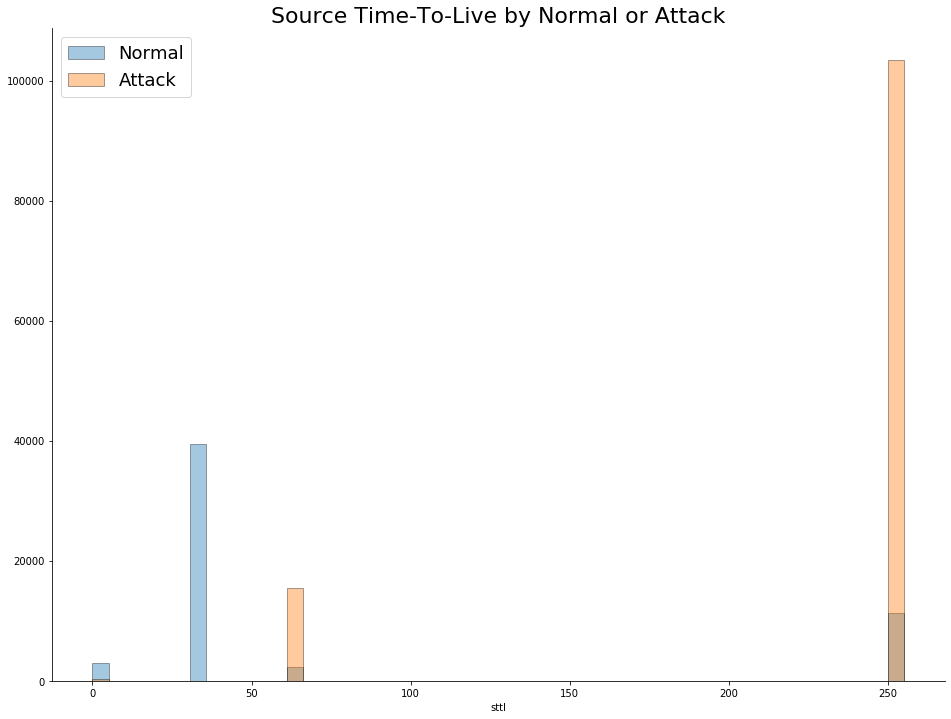

In [174]:
fig, ax = plt.subplots(figsize=(16,12))
p1 = sns.distplot(df.sttl[df.label == 0],bins=50,kde=False,hist_kws={"linewidth": .9, 'edgecolor':'black'})
p2 = sns.distplot(df.sttl[df.label == 1],bins=50,kde=False,hist_kws={"linewidth": .9, 'edgecolor':'black'})
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title('Source Time-To-Live by Normal or Attack',fontsize=22)
ax.legend(df.sttl,labels=['Normal','Attack'],fontsize = 18)
#plt.savefig('UNSW_sttl.png',format='png')
#files.download('UNSW_sttl.png')
plt.show;

In [94]:
sttl_greater_50 = df.attack_cat[(df.label == 1) & (df.sttl > 50)].value_counts()
sttl_greater_50

Generic           39997
Exploits          33222
Fuzzers           18169
DoS               12192
Reconnaissance    10467
Analysis           1997
Backdoor           1731
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

In [95]:
sttl_less_50 = df.attack_cat[(df.label == 1) & (df.sttl < 50)].value_counts()
sttl_less_50

Exploits          171
DoS                72
Reconnaissance     24
Fuzzers            15
Backdoor           15
Analysis            3
Generic             3
Name: attack_cat, dtype: int64

In [161]:
print('Percent of bad traffic sttl greater than 50: '+str(round(len(df[(df.label==1) & (df.sttl > 50)])/len(df[df.sttl > 50])*100,2))+'%')
print('Percent of bad traffic sttl less than 50: '+str(round(len(df[(df.label==1) & (df.sttl < 50)])/len(df[df.sttl < 50])*100,2))+'%')

Percent of bad traffic sttl greater than 50: 89.73%
Percent of bad traffic sttl less than 50: 0.71%


It is easy to see why sttl is such an important feature. If the sttl is less than 50, there is a 0.71 percent chance that the traffic is a bad actor, while at greater than 50 there is almost 9 in 10 chance of it being a bad actor.

**Definition: ct_dst_src_ltm**  
Number of connections of the same source [Source IP, feature 1] and the destination [Destination IP, feature 3] address in 100 connections according to the last time [Feature 26, Actual uncompressed content size of the data transferred from the server’s http service].

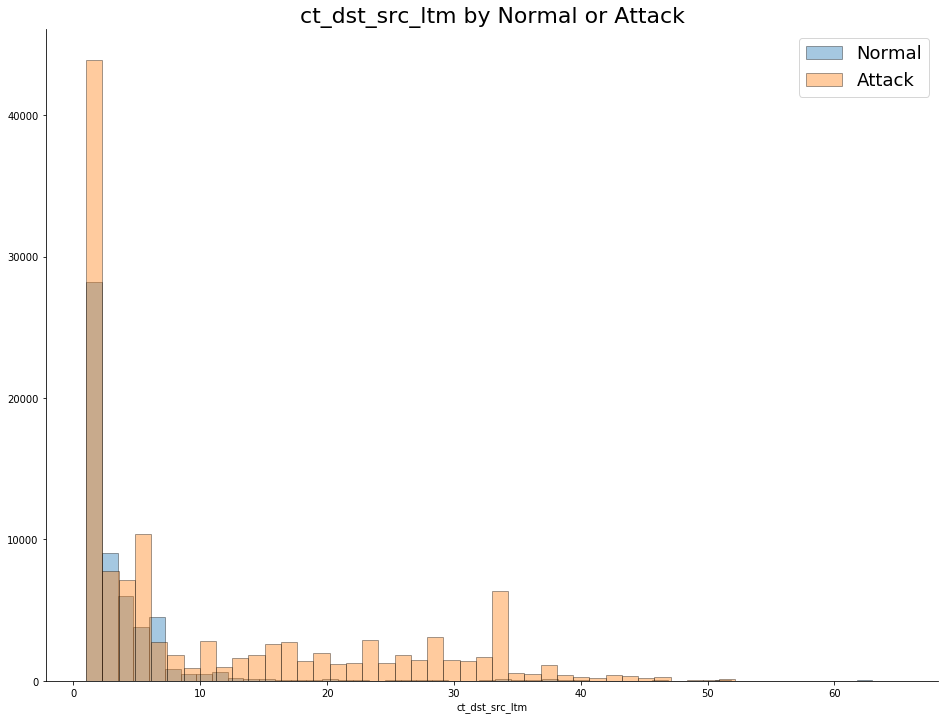

In [190]:
fig, ax = plt.subplots(figsize=(16,12))
sns.distplot(df.ct_dst_src_ltm[df.label == 0],bins=50,kde=False,hist_kws={"linewidth": .9, 'edgecolor':'black'},label='Normal')
sns.distplot(df.ct_dst_src_ltm[df.label == 1],bins=50,kde=False,hist_kws={"linewidth": .9, 'edgecolor':'black'},label='Attack')
plt.legend(fontsize=18)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title('ct_dst_src_ltm by Normal or Attack',fontsize=22)
#plt.savefig('UNSW_ct_dst_src_ltm.png',format='png')
#files.download('UNSW_ct_dst_src_ltm.png')
plt.show;

In [155]:
ct_dst_src_ltm_greater_10 = df.attack_cat[(df.label == 1) & (df.ct_dst_src_ltm > 10)].value_counts()
ct_dst_src_ltm_greater_10

Generic           37737
Exploits           1559
Fuzzers            1329
DoS                1313
Reconnaissance      411
Analysis            169
Backdoor            168
Shellcode            12
Name: attack_cat, dtype: int64

In [158]:
ct_dst_src_ltm_less_10 = df.attack_cat[(df.label == 1) & (df.ct_dst_src_ltm <= 10)].value_counts()
ct_dst_src_ltm_less_10

Exploits          31834
Fuzzers           16855
DoS               10951
Reconnaissance    10080
Generic            2263
Analysis           1831
Backdoor           1578
Shellcode          1121
Worms               130
Name: attack_cat, dtype: int64

In [164]:
print('Percent of bad traffic ct_dst_src_ltm greater than 10: '+str(round(len(df[(df.label==1) & (df.ct_dst_src_ltm > 10)])/len(df[df.ct_dst_src_ltm > 10])*100,2))+'%')
print('Percent of bad traffic ct_dst_src_ltm less than 10: '+str(round(len(df[(df.label==1) & (df.ct_dst_src_ltm <= 10)])/len(df[df.ct_dst_src_ltm <= 10])*100,2))+'%')

Percent of bad traffic ct_dst_src_ltm greater than 10: 94.45%
Percent of bad traffic ct_dst_src_ltm less than 10: 58.89%


**spkts**

In [188]:
df[df.spkts > 200]

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
1207,1208,43.541569,tcp,http,FIN,360,746,19202,1087890,25.378047,31,29,3.518293e+03,199612.828100,2,370,121.284845,58.444249,46460.842110,32274.723430,255,1416915617,1418311566,255,0.000813,0.000621,0.000192,53,1458,1,524288,2,0,5,1,1,1,0,0,1,6,3,0,Normal,0
1211,1212,43.239883,tcp,http,FIN,354,746,18890,1087890,25.416350,31,29,3.485116e+03,201005.531300,2,370,123.189738,58.039379,45176.759880,31149.187470,255,2076912432,4227751753,255,0.000698,0.000552,0.000146,53,1458,1,524288,2,0,5,1,1,1,0,0,1,1,3,0,Normal,0
1239,1240,37.955116,tcp,http,FIN,360,746,19202,1087890,29.113335,31,29,4.036136e+03,228993.000000,2,370,105.723731,50.945733,36460.897910,25323.102770,255,2871518349,2872607034,255,0.000676,0.000536,0.000140,53,1458,1,524288,3,0,15,1,1,3,0,0,1,9,2,0,Normal,0
1240,1241,41.748917,tcp,http,FIN,366,746,19514,1087890,26.611469,31,29,3.729151e+03,208183.984400,2,370,115.009994,56.038136,42074.225680,29403.324640,255,769429600,770616121,255,0.000676,0.000525,0.000151,53,1458,1,524288,2,0,5,1,1,2,0,0,1,9,1,0,Normal,0
1341,1342,24.432871,tcp,http,FIN,354,746,18890,1087890,44.980388,31,29,6.167756e+03,355728.000000,2,370,69.214123,32.795041,12501.322470,8611.425312,255,3037387409,3038533146,255,0.000727,0.000577,0.000150,53,1458,1,524288,2,0,5,1,1,2,0,0,1,3,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173799,173800,2.358193,tcp,-,FIN,258,42,330718,1816,126.792001,62,252,1.117591e+06,6014.774902,126,1,9.064132,55.433316,1017.836724,60.182246,255,1894173722,1446489174,255,0.122761,0.085419,0.037342,1282,43,1,0,1,1,1,1,1,1,0,0,1,1,1,0,DoS,1
173846,173847,6.484093,tcp,smtp,FIN,624,114,792979,5632,113.662771,62,252,9.768015e+05,6888.241699,309,8,10.407854,57.022344,1424.067017,85.436297,255,123426683,2055648681,255,0.044917,0.018338,0.026579,1271,49,0,0,1,1,1,1,1,1,0,0,0,1,1,0,Exploits,1
174548,174549,15.372617,tcp,-,FIN,204,1244,9024,1633778,94.128412,62,252,4.673245e+03,849544.375000,6,620,75.722392,12.313900,3694.714509,1508.086250,255,2498626068,1408337086,255,0.175144,0.078752,0.096392,44,1313,0,0,1,1,2,1,1,1,0,0,0,1,4,0,Exploits,1
174769,174770,36.410484,sctp,-,CON,250,24,248562,1652,7.497840,254,60,5.439488e+04,348.031616,0,0,146.226828,472.506875,217.958844,517.294969,0,0,0,0,0.000000,0.000000,0.000000,994,69,0,0,1,0,1,1,1,1,0,0,0,34,1,0,Generic,1


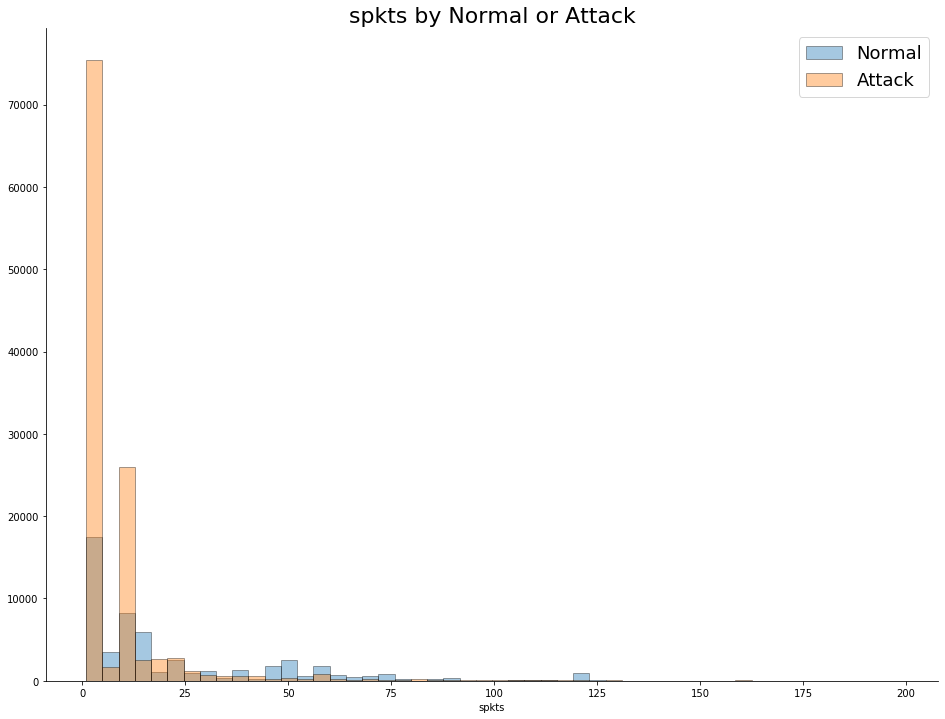

In [191]:
fig, ax = plt.subplots(figsize=(16,12))
sns.distplot(df.spkts[(df.label == 0) & (df.spkts < 200)],kde=False,hist_kws={"linewidth": .9, 'edgecolor':'black'},label='Normal')
sns.distplot(df.spkts[(df.label == 1)  & (df.spkts < 200)],kde=False,hist_kws={"linewidth": .9, 'edgecolor':'black'},label='Attack')
plt.legend(fontsize=18)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title('spkts by Normal or Attack',fontsize=22)
#plt.savefig('UNSW_spkts.png',format='png')
#files.download('UNSW_spkts.png')
plt.show;

**dload**

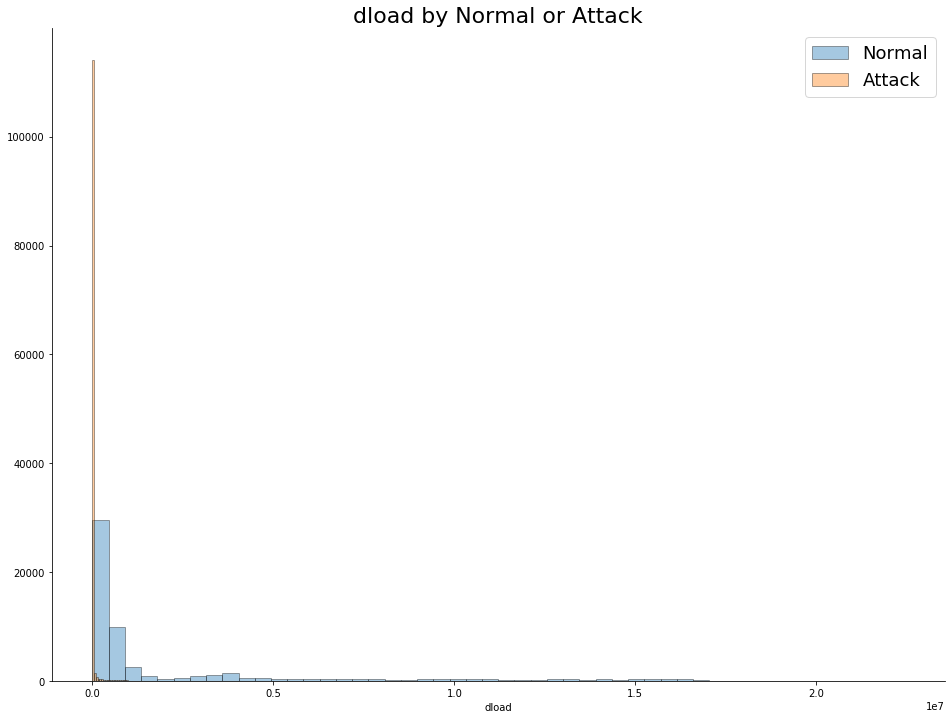

In [200]:
fig, ax = plt.subplots(figsize=(16,12))
sns.distplot(df.dload[df.label == 0],kde=False,hist_kws={"linewidth": .9, 'edgecolor':'black'},label='Normal')
sns.distplot(df.dload[df.label == 1],kde=False,hist_kws={"linewidth": .9, 'edgecolor':'black'},label='Attack')
plt.legend(fontsize=18)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title('dload by Normal or Attack',fontsize=22)
#plt.savefig('UNSW_dload.png',format='png')
#files.download('UNSW_dload.png')
plt.show;

**smean**

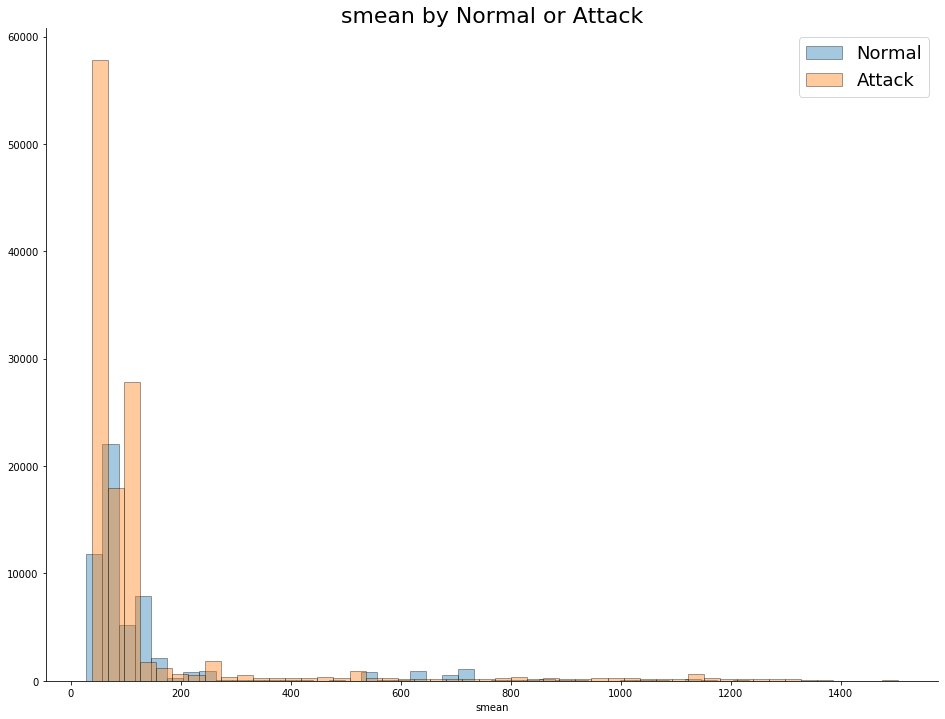

In [202]:
fig, ax = plt.subplots(figsize=(16,12))
sns.distplot(df.smean[df.label == 0],kde=False,hist_kws={"linewidth": .9, 'edgecolor':'black'},label='Normal')
sns.distplot(df.smean[df.label == 1],kde=False,hist_kws={"linewidth": .9, 'edgecolor':'black'},label='Attack')
plt.legend(fontsize=18)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title('smean by Normal or Attack',fontsize=22)
plt.savefig('UNSW_smean.png',format='png')
files.download('UNSW_smean.png')
plt.show;

**REFERENCES**  
T. Janarthanan and S. Zargari, "Feature selection in UNSW-NB15 and KDDCUP'99 datasets," 2017 IEEE 26th International Symposium on Industrial Electronics (ISIE), Edinburgh, 2017, pp. 1881-1886.  

D. Jing and H. Chen, "SVM Based Network Intrusion Detection for the UNSW-NB15 Dataset," 2019 IEEE 13th International Conference on ASIC (ASICON), Chongqing, China, 2019, pp. 1-4.  

N. Moustafa and J. Slay, "The Significant Features of the UNSW-NB15 and the KDD99 Data Sets for Network Intrusion Detection Systems," 2015 4th International Workshop on Building Analysis Datasets and Gathering Experience Returns for Security (BADGERS), Kyoto, 2015, pp. 25-31.  

N. Moustafa, J. Slay and G. Creech, "Novel Geometric Area Analysis Technique for Anomaly Detection Using Trapezoidal Area Estimation on Large-Scale Networks," in IEEE Transactions on Big Data, vol. 5, no. 4, pp. 481-494, 1 Dec. 2019.

L. Zhiqiang, G. Mohi-Ud-Din, L. Bing, L. Jianchao, Z. Ye and L. Zhijun, "Modeling Network Intrusion Detection System Using Feed-Forward Neural Network Using UNSW-NB15 Dataset," 2019 IEEE 7th International Conference on Smart Energy Grid Engineering (SEGE), Oshawa, ON, Canada, 2019, pp. 299-303.